In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from matplotlib import image
import random
from PIL import Image

## Set Global Variables and Load Images

In [3]:
UTKFACES_PATH = './UTKFace_without_other'
SPLIT_POSITION = -2
# there are two folders, one with all images and one where images labeled as other were removed
INCLUDE_OTHER_IMAGES = False

In [4]:
# Fetch image paths from folder
img_paths = []
with os.scandir(UTKFACES_PATH) as entries:
    img_paths = [img_path.path for img_path in entries]
    random.shuffle(img_paths)

In [5]:
# load image as pixel array, images are already preprocessed = centered and equal in size
imgs = [image.imread(img_path) for img_path in img_paths]

In [8]:
# preprocess labels, [-2] is the race info
race_labels = [int(img_path.split('_')[SPLIT_POSITION]) for img_path in img_paths]

In [9]:
# genereates a training, test and validation set as map 
def generate_sets(base_set, train, validation):
    idx1, idx2 = int(len(base_set) * train), int(len(base_set) * (train + validation))

    sets = {}
    sets["train"] = np.array([img for img in base_set[0:idx1]])
    sets["validation"] = np.array([img for img in base_set[idx1:idx2]])
    sets["test"] = np.array([img for img in base_set[idx2:]])  
    return sets


In [10]:
# create sets
trainig_set_size = 0.6
validation_set_size = 0.2
image_sets = generate_sets(imgs, trainig_set_size, validation_set_size)
race_label_sets = generate_sets(race_labels, trainig_set_size, validation_set_size)

In [8]:
# stores images in a folder e.g. to seperate training, test and validation images
def store_images(folder, images, labels):
    for i in range(0, len(images)):
        num = str(i)
        im = Image.fromarray(images[i])
        im.save('./' + folder + "/" + folder + "_" + num + "_" + str(labels[i]) + ".jpg")

In [10]:
# stores the image sets in different folders
store_images("train", image_sets["train"], race_label_sets["train"])
store_images("test", image_sets["test"], race_label_sets["test"])
store_images("validation", image_sets["validation"], race_label_sets["validation"])

In [14]:
# define possible classes, output layer 
if INCLUDE_OTHER_IMAGES:
    class_label = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
else: # removed other images
    class_label = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian'}

## Model Section (non CNN)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               15360128  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 15,368,644
Trainable params: 15,368,644
Non-trainable params: 0
_________________________________________________________________
Train on 13209 samples
Epoch 1/300
13209/13209 [==============================] - 15s 1ms/sample - loss: 9.5505 - sparse_categorical_accuracy: 0.4284
Epoch 2/300
13209/13209 [==============================] - 13s 1ms/sample - loss: 4.8509 - s

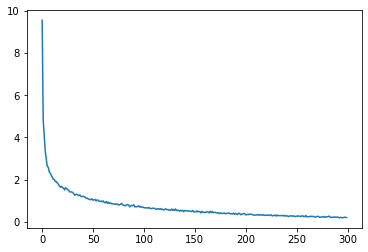

In [13]:
# parameters
RGB_DIMENSION = 3
OUTPUT_LAYER_SIZE = len(class_label)
EPOCHS = 300
BATCH_SIZE = 32
IMG_HEIGHT = IMG_WIDTH = 200
start, end = 0, len(image_sets["train"])
VERBOSE = 1 # 0: no outout, 1 progress bar, 2 one line per epoch

# create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, RGB_DIMENSION)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(OUTPUT_LAYER_SIZE, activation="softmax")
])

model.summary()

# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']    
)

# fit model
history = model.fit(
    image_sets["train"][start:end], # x_train == images
    race_label_sets["train"][start:end], # y_train == label value
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    verbose=VERBOSE)

# plot the history
plt.plot(history.history['loss'])

## Model Section (with CNN)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 193, 193, 32)      6176      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

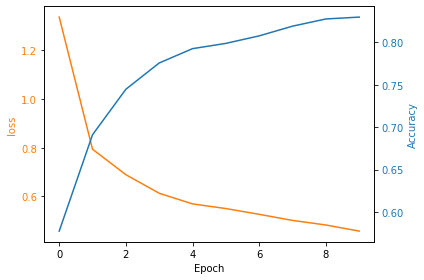

In [13]:
# parameters
OUTPUT_LAYER_SIZE = len(class_label)
EPOCHS = 10
BATCH_SIZE = 32
IMG_HEIGHT = IMG_WIDTH = 200
start, end = 0, len(image_sets["train"])
VERBOSE = 1 # 0: no outout, 1 progress bar, 2 one line per epoch

# create model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    
    # CNN
    tf.keras.layers.Convolution2D(32, (8,8), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((6,6)),
    
    tf.keras.layers.Convolution2D(32 , (4,4), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Convolution2D(64 , (4,4), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    # Fully Connected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(OUTPUT_LAYER_SIZE, activation="softmax")
])

# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'] 
)

model.summary()

# fit model
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(
    image_sets["train"][start:end], # x_train == images
    race_label_sets["train"][start:end], # y_train == label value
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    verbose=VERBOSE,
    callbacks=[earlyStop])

# plot the history
fig, ax1 = plt.subplots()
color = 'tab:orange'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss', color=color)
ax1.plot(history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(history.history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## Store Net and Tests

In [15]:
# fetch test sets
x_test, y_test = image_sets["test"][start:end], race_label_sets["test"][start:end]

# get loss and accuracy
test_loss, test_accuracy = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_accuracy)

4404/1 - 10s - loss: 0.5085 - accuracy: 0.7809

Test accuracy: 0.780881


In [14]:
# store the model
model.save('ralf_cnn_17-00_no_others.h5')

In [36]:
# test single images
ralf = tf.keras.models.load_model('ralf_cnn_00-44_no_others.h5')

img = image_sets["validation"][6]
label = race_label_sets["validation"][6]

img = tf.cast(img, tf.float32)
img = np.expand_dims(img, axis=0)

predicted_class = np.argmax(ralf.predict(img))

print('guessed correct' if class_label[predicted_class] == class_label[label] else 'guessed wrong')

guessed correct


### Bulk Test Function with Confusion Matrix Print

In [22]:
def bulktest(images, labels, start, end, model_name):
    model = tf.keras.models.load_model(model_name)
    test_images = images[start:end]
    test_label = labels[start:end]
    right = wrong = 0
    confusion_labels = []
    confusion_predicts = []
    
    for i in range(start, end):
        predicted_class = np.argmax(model.predict(np.expand_dims(tf.cast(test_images[i], tf.float32), axis=0)))

        confusion_labels.append(test_label[i])
        confusion_predicts.append(predicted_class)
        
        if class_label[predicted_class] == class_label[test_label[i]]:
            right += 1
        else:
            wrong += 1

    # Confusion Matrix Graphic
    con_mat = tf.math.confusion_matrix(confusion_labels, confusion_predicts, 4).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index = class_label, columns = class_label)
    plt.figure(figsize=(len(class_label), len(class_label)))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print("guessed " + str(right) + " correct and " + str(wrong) + " wrong : " + str(100 * (right / (right + wrong))) + "%")

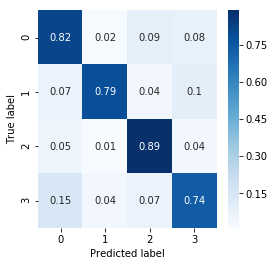

guessed 3231 correct and 769 wrong : 80.77499999999999%


In [23]:
# bulk test
bulktest(image_sets["validation"], race_label_sets["validation"], 0, 4000, "ralf_cnn_00-44_no_others.h5")